In [2]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [3]:
out = util.load("outfiles/Run3Summer22/old/cutflow_Run2022D.coffea")

In [ ]:
out = out[0]

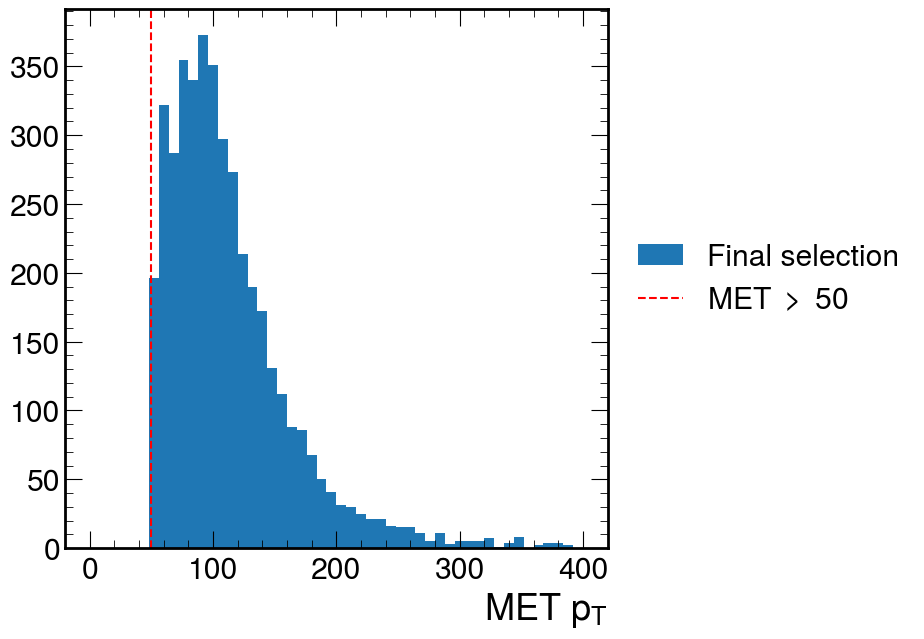

In [37]:
fig, ax = plt.subplots(figsize=(7,7))

for cut in ["all"]:

    h = out["met"].project("region", "pt")[hist.loc(cut), :]

    mplhep.histplot(h, label="Final selection", yerr=False, histtype='fill', alpha=1,)
    
#ax.set_yscale("log")
ax.axvline(50, color='red',ls='--', label=r"MET $>$ 50")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

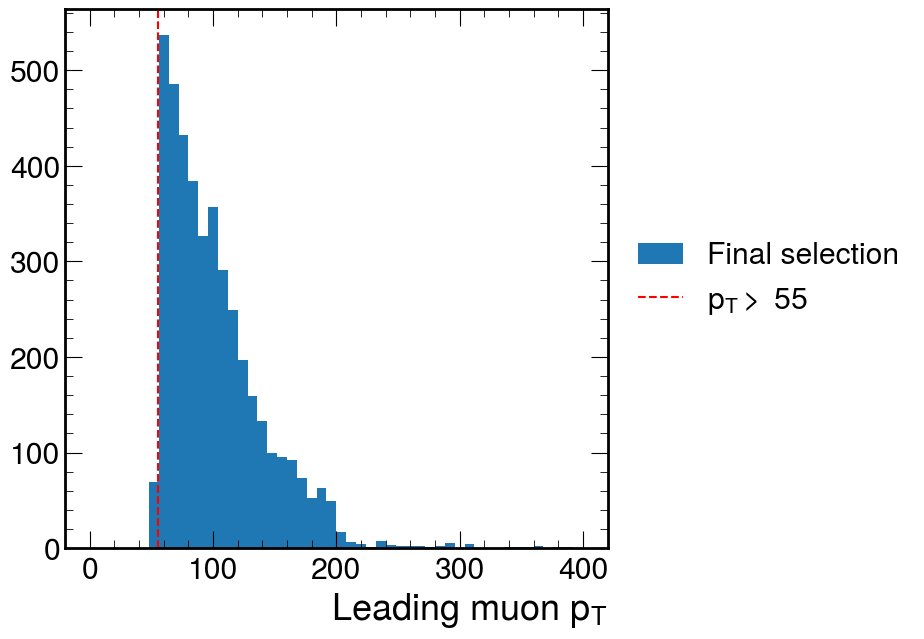

In [36]:
fig, ax = plt.subplots(figsize=(7,7))

for cut in ["all"]:

    h = out["goodmuon"].project("region", "pt")[hist.loc(cut), :]

    mplhep.histplot(h, label="Final selection", yerr=False, histtype='fill', alpha=1,)

#ax.set_yscale("log")
ax.axvline(55, color='red',ls='--', label=r"p$_T >$ 55")    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

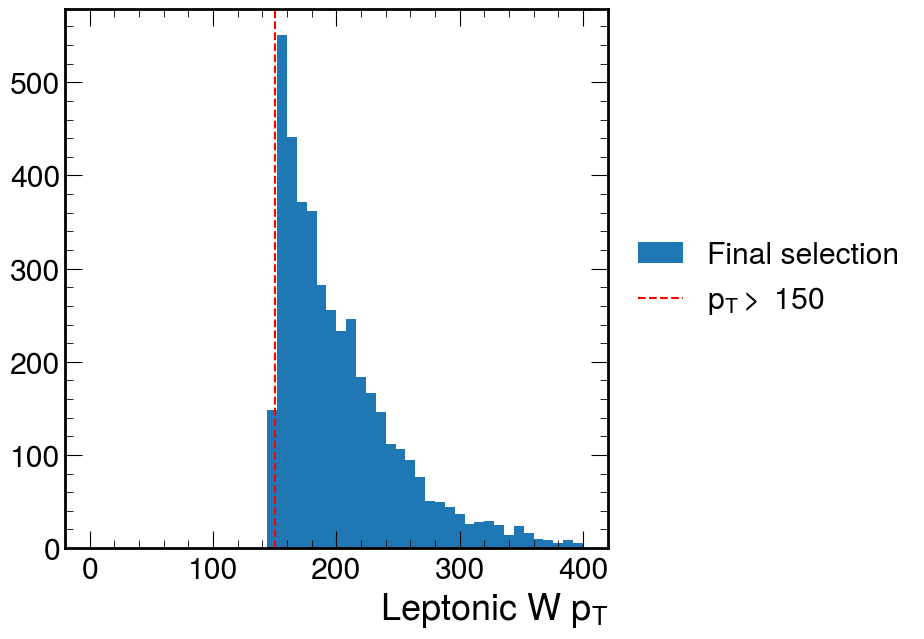

In [35]:
fig, ax = plt.subplots(figsize=(7,7))

for cut in ["all"]:

    h = out["leptonicW"].project("region", "pt")[hist.loc(cut), :]

    mplhep.histplot(h, label="Final selection", yerr=False, histtype='fill', alpha=1,)

#ax.set_yscale("log")
ax.axvline(150, color='red',ls='--', label=r"p$_T >$ 150")    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

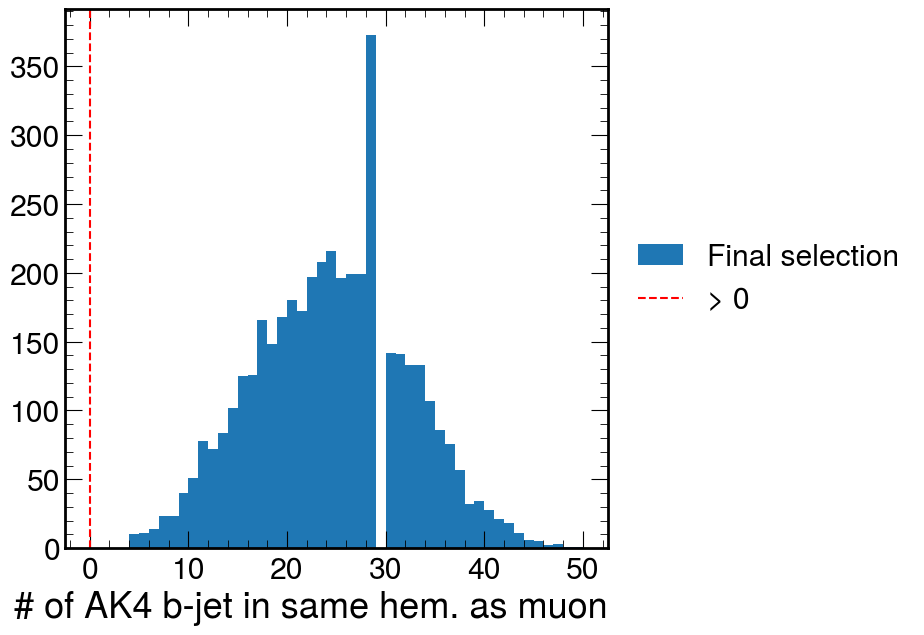

In [33]:
fig, ax = plt.subplots(figsize=(7,7))

for cut in ["all"]:

    h = out["ak4bjet"].project("region", "njets")[hist.loc(cut), :]

    mplhep.histplot(h, label="Final selection", yerr=False, histtype='fill', alpha=1,)

ax.set_xlabel(r"# of AK4 b-jet in same hem. as muon")
ax.axvline(0, color='red',ls='--', label=r"> 0")    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

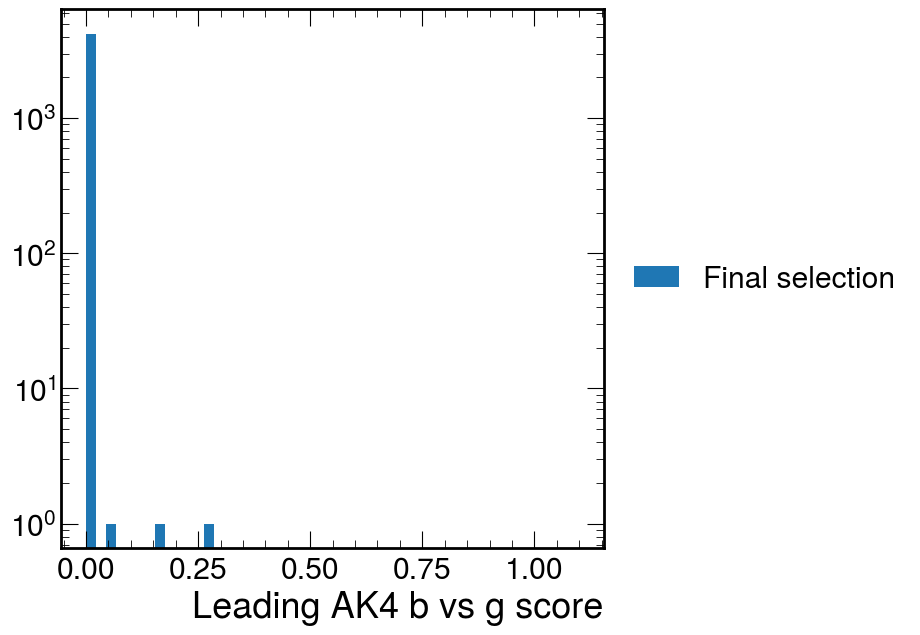

In [34]:
fig, ax = plt.subplots(figsize=(7,7))

for cut in ["all"]:

    h = out["ak4bjet"].project("region", "pn_b_1")[hist.loc(cut), :]

    mplhep.histplot(h, label="Final selection", yerr=False, histtype='fill', alpha=1,)

ax.set_yscale("log")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

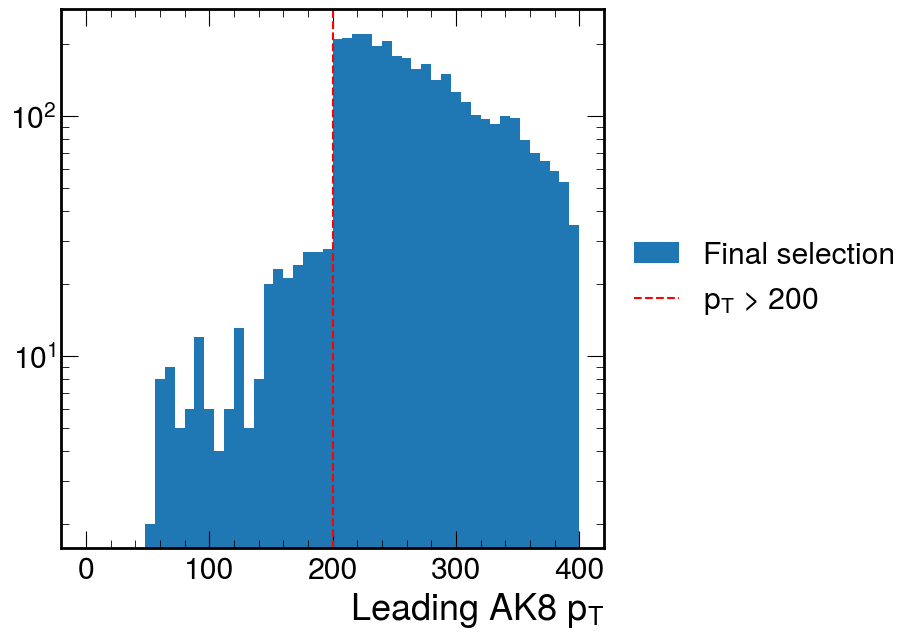

In [38]:
fig, ax = plt.subplots(figsize=(7,7))

for cut in ["all"]:

    h = out["ak8jet"].project("region", "pt")[hist.loc(cut), :]

    mplhep.histplot(h, label="Final selection", yerr=False, histtype='fill', alpha=1,)

ax.set_yscale("log")
ax.axvline(200, color='red',ls='--', label=r"p$_T$ > 200")    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

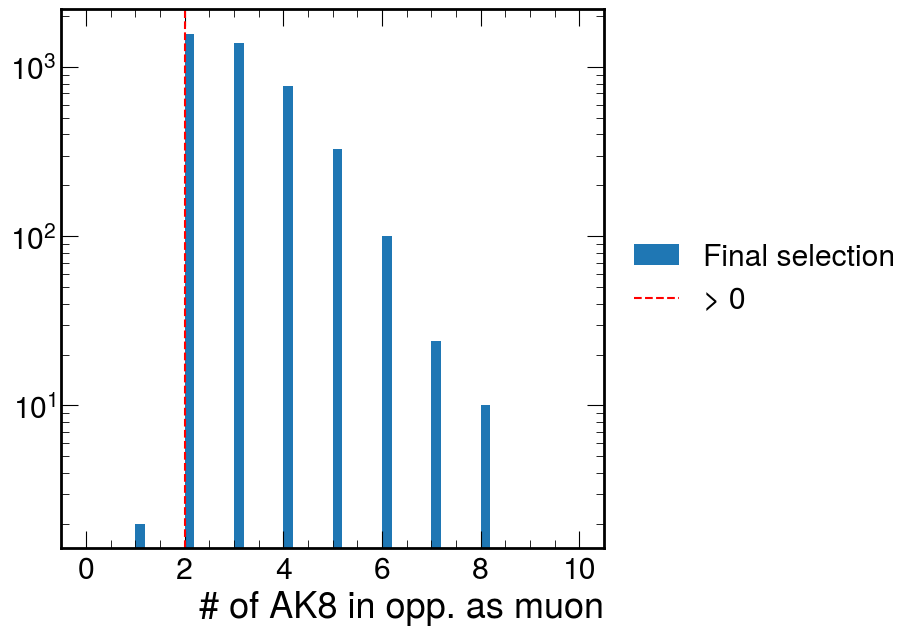

In [41]:
fig, ax = plt.subplots(figsize=(7,7))

for cut in ["all"]:

    h = out["ak8jet"].project("region", "njets")[hist.loc(cut), :]

    mplhep.histplot(h, label="Final selection", yerr=False, histtype='fill', alpha=1,)

ax.set_yscale("log")
ax.set_xlabel(r"# of AK8 in opp. hem. of muon")
ax.axvline(2, color='red',ls='--', label=r"> 0")    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))